# Material de apoio

Ainda não incluímos nada aqui.

# Introdução a aprendizado de máquinas

Na aula anterior usamos momentaneamente o tipo de pensamento ligado ao desenvolvimento de aprendizado de máquinas para avaliar uma regressão logística. Nessa aula vamos falar um pouco mais desse tema.

# Melhorando um modelo preditivo

Muitos fatores poderiam ser adicionados ao modelo atual para tentar aumentar a sua capacidade preditiva.

Por exemplo, poderíamos considerar que não incluímos uma informação importante sobre o que estamos tentando prever e buscar adicionar essa informação. Nessa linha poderíamos buscar na literatura hipóteses do que motivam o comportamento judicial, e incluir variáveis que meçam o alinhamento político dos juízes e da questão jurídica do caso.

Outra opção é sermos criativos e considerar como podemos usar as informações que temos a nossa disposição. Muitas vezes podemos obter variáveis novas a partir dos dados já disponíveis. Um exemplo disso foi quando criamos uma variável que indica a diferença no PIB entre as partes do processo a partir das variáveis individuais.

Esse tipo de trabalho pode melhorar muito modelos, e muitas vezes depende de um conhecimento específico do domínio no qual estamos trabalhando. Assim, como juristas poderíamos ser especialistas em determinado assunto e ajudar a criar ou selecionar variáveis de interesse para um modelo.

Por fim, uma última possibilidade é usar modelos mais complexos que sejam capazes de extrair mais dos dados que temos a nossa disposição. No geral, esse tipo de opção tem alguns custos: precisamos de maior conhecimento do procedimento de aprendizado por máquina, tomar alguns cuidados para não gerrar erros metodológicos, e eles podem necessitar de uma volume maior de dados.

Nessa aula vamos explorar um pouco sobre como construir modelos de aprendizado de máquinas e mencionar alguns problemas com os quais precisamos ter cuidado.

Vamos carregar novamente os dados da última aula. Perceba que estamos agora carregando já com as variáveis que criamos na última aula.


In [1]:
import pandas as pd

icj = pd.read_csv("https://bit.ly/3l1AldC")

icj.head()

,caseNumber,caseName,respEU,respGDP,respLegalTrad,decision1,judgeEU,judgeGDP,judgeLegalTrad,appEU,appGDP,appLegalTrad,jurisBasis,trad_equals_pet,parties_GDP_dif
0,C0.5,Corfu Channel (Preliminary Objection),0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,english,special clause,0,NaN
1,C1,Corfu Channel,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,english,special clause,0,NaN
2,C1.5,Corfu Channel (Assessment of Compensation),0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,english,special clause,0,NaN
3,C56,Certain Phosphate Lands in Nauru,0.0,19573.818359,english,1.0,0.0,4209.721191,NaN,0.0,NaN,NaN,special clause,0,NaN
4,C59,East Timor,0.0,21771.312500,english,0.0,0.0,4245.033691,NaN,1.0,12906.996094,french,special clause,0,8864.316406


# Outros modelos preditivos

O problema que estamos enfrentando até agora é uma instância de um problema de **classificação** que pode ser enfrentado por aprendizado de máquina ou machine learning. Mais especificamente, estamos falando de aprendizado supervisionado.

Por quê?

Porque temos um conjunto de dados de treinamento que possui dados anotados (sabemos o valor da Variável Depnendente) e queremos *descrever as relações estatísticas entre a DV e as IVs*.

Como mencionamos, uma maneira de tentar melhorar a nossa performance em uma tarefa de classificação é *mudar qual é o método que estamos usando*. Até agora, usamos sempre regressões logísticas para tentar prever os resultados dos processos.

Agora, vamos tentar usar um método um pouco diferente: a **árvore de decisão**.

A biblioteca mais usado e com maior número de modelos "canônicos" de aprendizado de máquina é a [scikit-learn](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning), importada como sklearn dentro do python.

Vamos importar a função do classificador de arvore de decisão:

In [33]:
from sklearn.tree import DecisionTreeClassifier

Para trabalhar com algoritmos de aprendizado de máquina precisaremos alterar um pouco a estrutura de nosso código.

Em primeiro lugar, cada modelo tem funcionamento e é capaz de lidar com dados de forma distintas. Além disso, podemos ajustá-los através do que chamamos de hiperparâmetros.

Um ponto importante é que não mais podemos usar a sintaxe de fórmula que vimos nas últimas aulas e precisamos sujar mais as mãos para lidar com nossos dados.

Por exemplo, se tivermos uma variável categórica iremos preicsar transformá-la explicitamente (mas não do 0, o pandas já faz isso para nós) antes de passá-la para o modelo.

Vamos ver como proceder, e também alguns outros cuidados necessários.

Primeiro vamos separar as colunas que usamos no último modelo construído e ver se há valores não preenchidos.

In [34]:
icj_modelo = icj[
    ["trad_equals_pet", "parties_GDP_dif", "judgeGDP", "jurisBasis", "decision1"]
].copy()

icj_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   trad_equals_pet  1560 non-null   int64  
 1   parties_GDP_dif  854 non-null    float64
 2   judgeGDP         1198 non-null   float64
 3   jurisBasis       1555 non-null   object 
 4   decision1        1502 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 61.1+ KB


Podemos observar que algumas das variáveis tem menos valores preenchidos. Mas nosso modelo usava todos esses valores, o que ocorre se um deles está faltando?

Faz sentido manter casos em que há informação faltando?

Se voltarmos nas tabelas da última aula veremos que o número de observações é inferior ao de todos esses valores. Isso ocorre porque o `statsmodels` automaticamente descartava todas as linhas em que um desses valores não era preenchido.

Agora precisamos fazer isso manualmente.

In [35]:
icj_modelo.dropna(inplace=True)

icj_modelo.shape

(734, 5)

Ficamos com apenas 734 observações.

Agora precisamos transformar nossas variáveis categóricas no que chamamos de variáveis "dummies". Queremos expressá-las em termos numéricos em que cada característica será indicada como 0 ou 1. Isso foi feito pelo statsmodels fez para nós automaticamente.

Para isso temos uma função do panda que resolve nosso problema se passarmos uma dataframe apenas com as colunas que queremos transformar. No nosso caso, apenas a base da jurisdição.

Vejamos:

In [36]:
dum_vars = pd.get_dummies(
    icj_modelo["jurisBasis"],
    drop_first=True
)

dum_vars.head(3)

,special clause,treaty
4,1,0
11,1,0
14,1,0


**Para obtermos o comportamento desejado precisamos também passar o argumento `drop_first=True`.**

Afinal, já temos todas as informações para classificar. Considere: se tanto special clause quanto treaty não ocorrem (forem 0), podemos concluir que necessariamente tratamos de um caso de special agreement, já que são todas as categorias disponíveis.

vamos criar um dataframe com nossas variáveis independentes (IVs) e separar nossa variável dependente (DV).

In [37]:
# vamos juntar as colunas originais relevantes com nossas dummies
# vamos usar o indíce nesse caso já que não temos um identificador
df_iv = icj_modelo[
    ["trad_equals_pet", "parties_GDP_dif", "judgeGDP"]
].merge(dum_vars, left_index=True, right_index=True)

df_iv.head(3)

,trad_equals_pet,parties_GDP_dif,judgeGDP,special clause,treaty
4,0,8864.316406,4245.033691,1,0
11,0,7614.755859,4540.739258,1,0
14,0,2716.447266,4245.033691,1,0


In [38]:
# separar variavel independente
dv = icj_modelo["decision1"]

# criar a árvore padrão
classificador_arvore = DecisionTreeClassifier()

# vamos treiná-lo em nossos dados
classificador_arvore.fit(
    X=df_iv,
    y=dv
)

DecisionTreeClassifier()

Agora temos uma árvore treinada!

Ao contrário das regressões, outros modelos de machine learning não possuem o mesmo tipo de parâmetros que podemos interpretar de uma tabela.

A forma padrão para avaliar é sua capacidade de prever o resultado de **novos** casos. 

No próximo tópico iremos comentar essa qualificação dos casos, mas vamos deixá-la de lado e repetir a avaliação que fizemos na última aula com os mesmos casos.

Vamos começar com a acurácia (percentual de casos previstos corretamente).

In [39]:
previsao_arvore = classificador_arvore.predict(df_iv)

(previsao_arvore == dv).mean()

0.9945504087193461

Nossa árvore acertou 99,5% dos casos! Isso parece incrível. Certamente é bom demais para ser verdade, mas antes de confirmar esse problema vamos calcular as outras métricas.

In [40]:
from sklearn.metrics import classification_report

print(classification_report(dv, previsao_arvore))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       372
         1.0       1.00      0.99      0.99       362

    accuracy                           0.99       734
   macro avg       0.99      0.99      0.99       734
weighted avg       0.99      0.99      0.99       734



# O problema de testar no próprio conjunto de treinamento

Na maioria das vezes em que desenvolvemos um modelo de classificação pretendemos fazer previsões a respeito de dados que não conhecemos. Assim, olhar para a performance do modelo apenas no próprio conjunto no qual ele foi treinado pode ser problemático. Na prática, pode ser que o modelo aprenda exatamente quais são os pontos do conjunto de dados e abstraia uma função que é excessivamente próxima ao conjunto original. Assim, o erro dessa função em dados verdadeiramente novos pode ser muito alto. Esse é um problema chamado pela literatura de aprendizado de máquina de "overfitting".

Para combater o overfitting, a estatégia adotada é "treinar" o modelo em um conjunto de dados diferente daquele que vamos usar para medir a sua performance. Em geral, isso é feito dividindo aleatoriamente o conjunto de dados em subconjuntos de treino e teste (algumas vezes também temos um conjunto de validação).

Outra opção é fazer divisões temporais. Vamos considerar que desejamos prever o resultado de decisões do STF.

Sabemos que o STF faz julgamentos em lista. Com isso, dezenas de processos recebem, no mesmo dia, uma decisão de texto idêntico. Se fizermos a divisão em conjuntos de treinamento e teste aleatoriamente, é praticamente certo que terminaremos com um mesmo lote representado no conjunto de treinamento e no conjunto de teste. Assim, o problema do overfitting continua existindo. Para contornar esse problema, poderíamos treinar em um ano anterior - por exemplo, 2018 - e testar o nosso modelo em um ano posterior, 2019.

No nosso caso da ICJ, vamos tentar adotar o primeiro caminho e separar 20% dos dados para teste.

In [41]:
from sklearn.model_selection import train_test_split

# vamos usar a função do sklearn desenhada para isso e fixar seu fator aleatorio
iv_train, iv_test, dv_train, dv_test = train_test_split(df_iv, dv, random_state=108)

Vamos treinar uma nova árvore em nosso conjunto de treino e tentar prever o conjunto de testes.

In [42]:
# treinar em uma única linha
classificador2 = DecisionTreeClassifier().fit(
    X=iv_train,
    y=dv_train
)

# prever no teste e medir o resultado
prev_test = classificador2.predict(iv_test)

print(classification_report(dv_test, prev_test))

              precision    recall  f1-score   support

         0.0       0.79      0.71      0.75        84
         1.0       0.78      0.84      0.81       100

    accuracy                           0.78       184
   macro avg       0.78      0.78      0.78       184
weighted avg       0.78      0.78      0.78       184



Ainda assim nossa árvore de decisão parece ser consideravelmente melhor que a regressão logística.

A rigor, não tomamos todas as precauções necessários. Um projeto de desenvolvimento de modelo de aprendizado supervisionado inclui também um conjunto de validação. Esse conjunto não é visto sequer por quem está criando o algoritmo para preservar qualquer tipo de viés no desnevolvimento.

A ideia é manter um conjunto intocado no qual o modelo será testado de fato sem termos nenhum conhecimento desses dados.

## Outros cuidados com aprendizado de máquina.

Existem outros problemas que precisamos ter cuidado pensando que queremos generalizar nosso modelo sobre um fenômeno.

Todos os juízes estão bem representados nesses dados? Será que podemos aplicar esse mesmo modelo se trocarmos os juízes da corte?

Lembre-se que nossa unidade é de decisão, será que pode ocorrer algum problema na forma como aprendemos do mesmo processo judicial?

Será que houve algum viés na forma como coletamos os dados (precisamos manter apenas aqueles em que achamos todas as informações usadas)?

Nem todas essas perguntas tem resposta, mas precisamos pensar sobre essas questões difíceis e lembrar que todo modelo tenta aproximar o mundo real. Com isso, temos também problemas não necessariamente técnicos.

Se o modelo aproxima um processo do mundo real, e esse processo é feito por pessoas, será que nosso modelo pode estar aprendendo e repetindo algum tipo de viés?

Cada uma dessas perguntas envolve um grande esforço de estudo e pesquisa para avaliar e ser respondida, e vamos deixá-las em aberto aqui.

Um outro problema de modelos de aprendizado de máquina é não conseguimos interpretrar bem como ocorre a classificação.

Na verdade, para árvores de decisão podemos criar uma imagem das regras aplicadas pela árvore. Mas isso deixa de ser verdade se passarmos para modelos mais complexos (e poderosos) que costumam ser chamados de "caixas pretas".

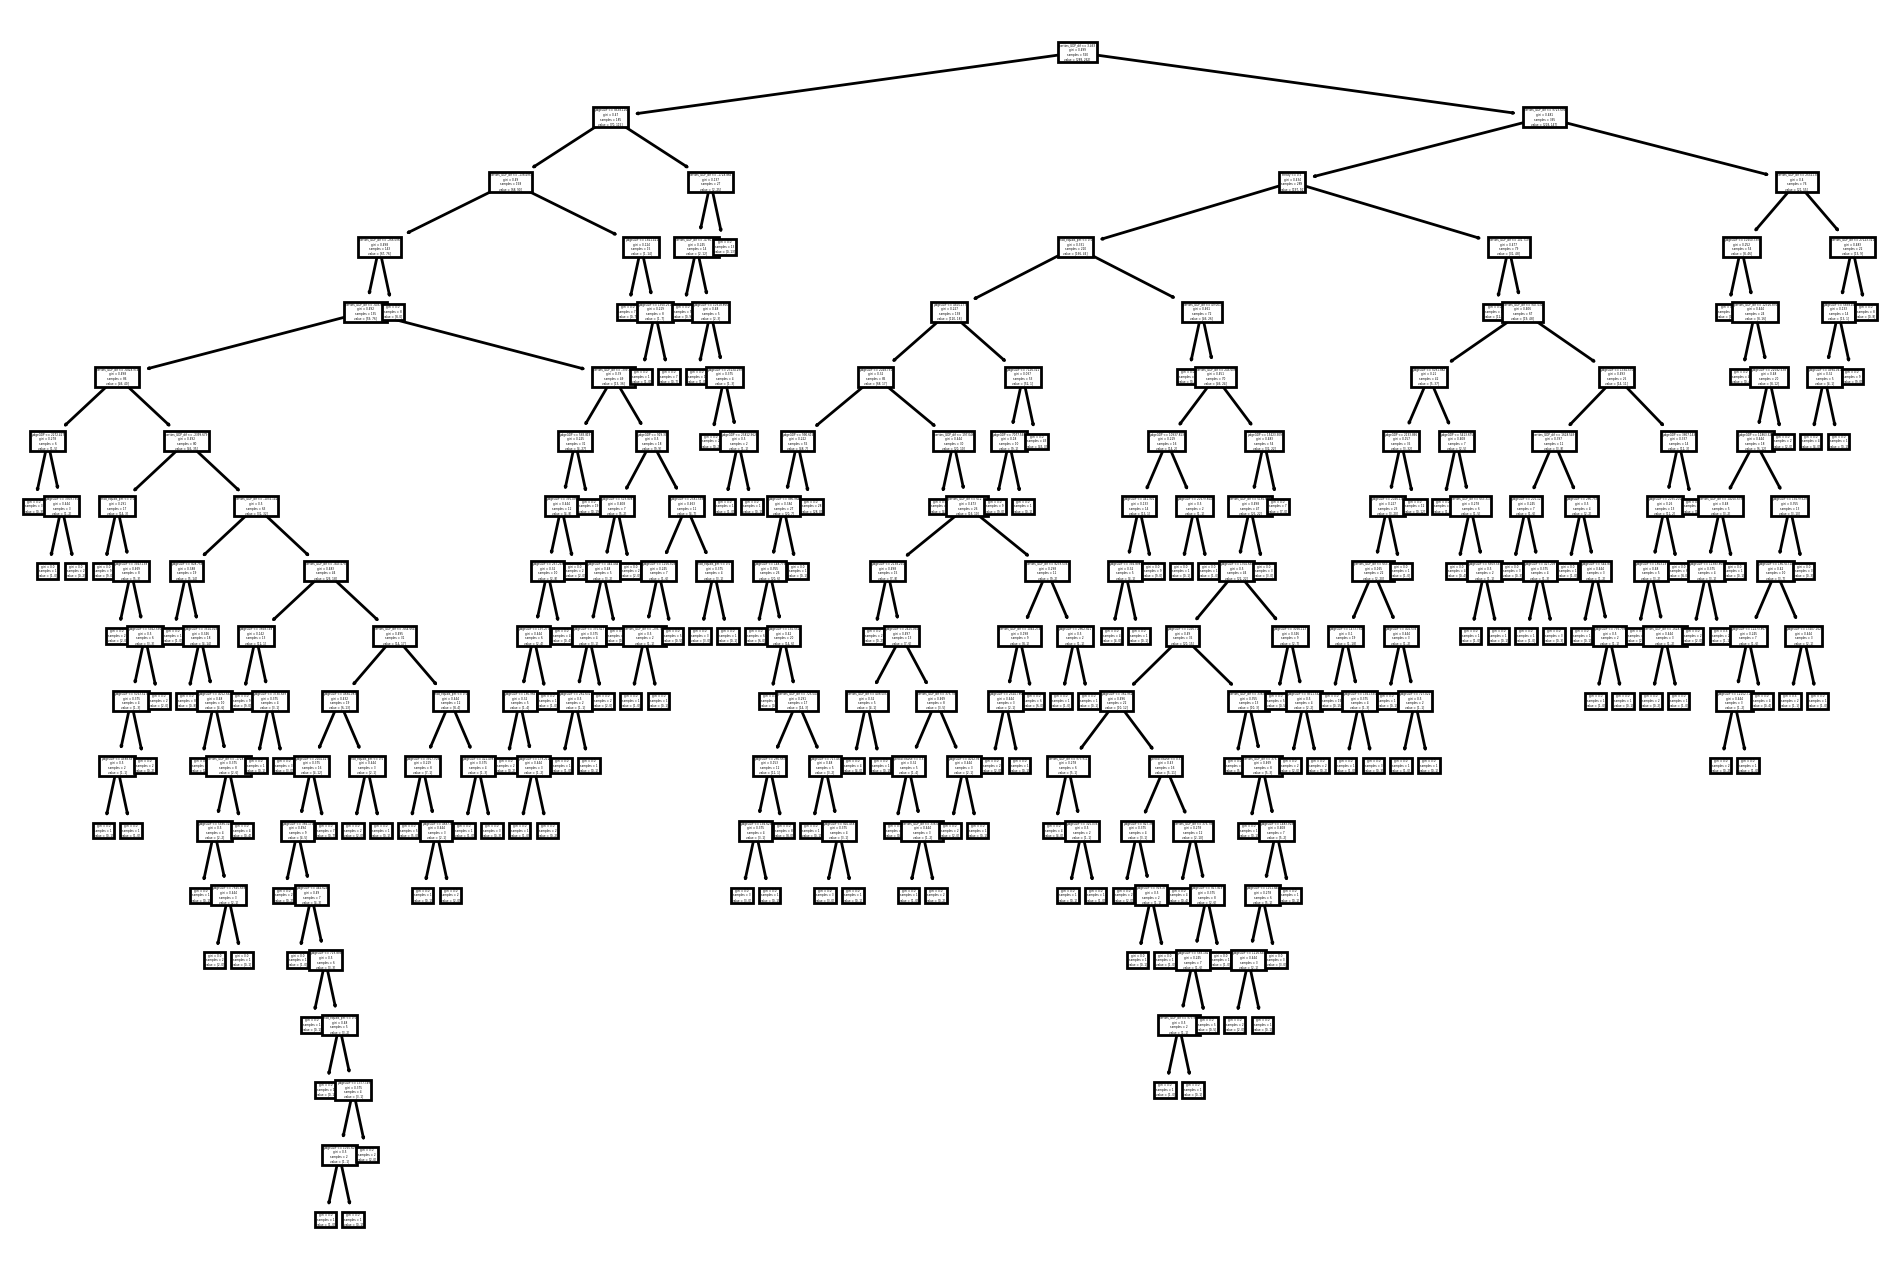

In [50]:
from sklearn import tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8), dpi=200)

_ = tree.plot_tree(
    classificador2,
    feature_names=iv_test.columns,
    ax=ax
)

Há algum problema com nossa árvore? Podemos interpretá-la facilmente?

O que precisaríamos mudar?

# Desafio

Construa um modelo de árvore de decisão para prever o resultado de um processo na ICJ.

Não foque agora em criar um modelo melhor mas em criar uma árvoer que seja mais facilmente interpretável. Considere quantas normas diferentes desejamos usar para classificar os casos sem que isso criem um modelo muito complexo ou que trate casos específicos.

Crie agora a visualização da sua árvore

## Exercício 2

Uma alternativa possível para conseguir uma performance melhor é simplesmente utilizar modelos mais sofisticados. Vamos tentar usar um modelo de random_forest (floresta aleatória) para prever o resultado dos processos.

Para explicar brevemente, a idéia por trás desse modelo é que podemos ter uma previsão melhor se combinarmos várias árvores de decisão. Cada árvore de decisão é treinada em um subconjunto (amostra) dos dados e a previsão final é feita agregando as previsões de cada árvore. A expectativa é que na média o conjunto de árvores desempenhe melhor que uma única árvore.

O código para criar esse classificador segue o mesmo modelo para a árvore de decisão, contudo em vez de usar a função `DecisionTreeClassifier` usaremos a função `RandomForestClassifier`, já importada na célula abaixo.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# seu código aqui